## Welcome to E-tivity 2, Task 1: Artificial Neural Networks Revisited

Your Name: Zheng Hanming

Your Student ID Number: 21225621

### Objective:
*Address a Regression problem using an Artificial Neural Network*

### Important Notice
*Given the subjectivity that goes in to the parameters and hyper-parameters underlying a Neural Network (no matter how simple),
and the range of choices that may produce a 'good' result, you will be required to provide reasoning for your choices in
your post e-tivity reflection. Specifically, you are required to reflect on your implementation of Subtasks 2, 3, and 4,
and on the model that provides a superior performance in validation tests. This includes:*

1. *providing your rationale for the hidden layer specifications when forming the Neural Network architecture, and*
2. *the choice of hyperparameters used to train the model, and providing a couple potential reasons for the result*

*In addition, if you choose to deviate from the 'default' option in Subtask 2, you will be required to provide your rationale.*

*To facilitate this, you may make use of the 'Results & Reflection' markdown text box at the end of the notebook, wherein
you may describe your approach to each task that is subject to interpretation (e.g. choice of parameters included, choice
of neurons and layers in a neural network, etc.) following every task, such that your rationale and line of thinking can
be threaded through the script.*

*The best-performing network (performed on an additional holdout set following e-tivity submission) gets 2 extra marks in
addition to the rubric-graded scores, so long as it remains within the specifications identified in the notebook.*

### More Information
#### A Regression Problem
### Predicting, using firm data, bond data, ESG data, and accounting data, the extent to which a firm's stock will outperform the wider market in the couple days after the firm announces the upcoming sale of a 'Green Bond'.
Why accounting data? When a firm announces an upcoming bond, it is essentially stating that it is willing to take
on debt from the public in return for immediate access to cash (you pay the firm for the bond, they pay you back over time).

When a bond in announced, there is an implicit assumption amongst investors that the firm will be able to pay it back.
Investors will want assurance that the firm has the capability to pay the full amount of the debt back, on top of interest,
and that repayments will not hamper growth efforts within the firm (new profitable project ventures). The first place investors will look
is the latest publicly-available accounts of the firm, which gives an in-depth look into the financial strength of the firm, and
an insight into the level of debt that the firm is *already* paying back.

The main reason for the investors' due diligence is to gauge their interest in purchasing the bond. A byproduct of this
is a movement in the underlying share price of the firm. If investors like what they see, they will make their sentiments
known by buying the stock and increasing the share price of the firm. If investors do not approve the announcement, they
will similarly make their sentiments known by selling the stock. Although the evidence is mixed on whether equity investors
react strongly to conventional bond announcements, there is evidence that equity investors **are** sensitive to Green Bond announcements.
We want to see if we can identify the factors that influence equity investor behaviours.

The dataset being used here is compiled of a number of indicators that are typically used as 'signals' for the general financial
strength of a firm - it may not cover all bases, but it certainly covers some important ones.

All bonds that have been ever been released by publicly-listed firms (at the time of writing) and designated as a bond where *the funds will be used to
contribute to Green Initiatives* are considered in this dataset (from 2013-EoY2021). That means excluding government-released Green Bonds,
and Green Bonds released by private corporations. The result is 1,760 Green Bond announcements over the course of ~8.5 years.

### PyTorch
Note that for this module, we will be implementing neural networks using PyTorch instead of TensorFlow or Keras. You can
find out more about PyTorch here: https://pytorch.org/features/.

#### Install required packages and libraries:

In [26]:
# !pip install -U setuptools
# !pip install pandas numpy matplotlib missingno scikit-learn torch

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno
import traceback, re
import torch

from sklearn import preprocessing

from torch.utils.data import (TensorDataset, DataLoader, Subset)
from torch import (nn, optim)

%matplotlib inline
print(torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# setting seed for reproducibility - please do not change
torch.manual_seed(25)


2.0.0+cpu


# Data Import and Initial Inspection

In [28]:
GreenBonds = pd.read_csv('GreenBonds_LinearOutput.csv')
GreenBonds.dtypes

Issuer_Name                               object
CUSIP                                     object
Long_Cost                                 object
Short_Cost                                object
Equity_Ticker                             object
BICS_L1                                   object
Announcement_Date                         object
Issue_Date                                object
Maturity                                  object
Number_Bonds_Issued                        int64
Bond_FX_Rate_USD                         float64
Option_Embedded                            int64
High_Yield_Issuer                          int64
Average_3Y_Issuer_Default_Probability    float64
Previous_Green_Bond_by_Firm                int64
CDP_Climate_Score                        float64
ESG_Disclosure_Score                     float64
Average_3Y_EBITDA_L_CAPEX_TO_INT_EXP     float64
Average_3Y_TOT_DEBT_TO_TOT_ASSET         float64
Average_3Y_COM_EQY_TO_TOT_ASSET          float64
Average_3Y_FreeCashF

#### Note that all of the following variables may be useful in your analysis, but not all need to be included (open to interpretation in Subtask 2)

#### Firm Data
- **Issuer_Name**: Firm to which the bond is attached (may be subsidiary/offshoot of parent firm)
- **Equity_Ticker**: Ticker of Parent Firm
- **BICS_L1**: Industry Classification of the firm
- **Number_Bonds_Announced**: Number of bonds the firm will issue as part of the announcement
- **Previous_Green_Bond_by_Firm**: Whether the firm has previously issued 'Green Bonds'
- **High_Yield_Issuer**: Binary indicator specifying whether the firm has a low credit rating (1) or high credit rating (0)
- **Average_3Y_Issuer_Default_Probability**: End of year measure indicating probability that the firm will default over the next year, on average, over the last 3 years.
The 'default probability' formula is proprietary, and only the results are provided by Bloomberg.
- **CDP Climate Score**: Level of company commitment to climate change mitigation, adaption, and transparency (scale 0-10)
- **ESG_Score**: Bloomberg score based on the extent of a company's Environmental, Social, and Governance (ESG) disclosure. For those who report, score ranges from 0.1 to 100, and score measures the amount of ESG data a company reports publicly.

#### Bond Data
- **Announcement_Date**: Date bond was announced
- **Issue_Date**: Date bond was expected to be issued
- **Maturity**: Date bond was expected to expire at time of announcement
- **Bond_FX_Rate_USD**: Foreign Exchange Rate of denominated Bond Currency relative to the US Dollar at the time of announcement
- **Option_Embedded**: Whether at least one of the bonds released as part of the announcements came with an option embedded in the payout structure

#### Accounting Data
> Values for the below are based on the latest figures available to public shareholders at the end of the financial year prior to the bond being announced (i.e. if bond is announced in March 2015, accounting data figures are taken from those available on 31st December 2014).

- **Average_3Y_EBITDA_L_CAPEX_TO_INT_EXP**: End of year ( EBITDA - Capital Expenditure ) / Interest Expenses ratio within the firm, on average, over the last 3 years, where EBITDA is a measure of core business profitability, which when
computed alongside Capital Expenditure represents a measure of profitability efficiency, while interest expenses represent the cost incurred by an entity for borrowed funds. In short, indicator as a whole is a measure of profit-making ability relative to ongoing debt repayments.
- **Average_3Y_TOT_DEBT_TO_TOT_ASSET**: End of year Total Debt / Total Asset ratio within the firm, on average, over the last 3 years. A measure of debt burden.
- **Average_3Y_COM_EQY_TO_TOT_ASSET**: End of year total USD amount that common shareholders have as a 'stake' in the firm as a result of having investments in the firm, on average, over the last 3 years, relative to Total Assets. A measure of tangible firm value relative to total firm value.
- **Average_3Y_FreeCashFlow_to_NetIncome**: End of year Free Cash Flow in the firm, on average, over the last 3 years, relative to Net Income margin.
Both FCF and NI are indicators of profitability and financial performance, but account for different sales and cost items.
FCF/NI is a measure of capital efficiency (higher FCF/NI margin = lower capital intensity), and flexibility to manoeuvre and scale operations.

#### Target Data
- **Two_day_After_Excess_Return**: Extent to which the firm's stock outperformed the market, as measured by returns 2-days post the bond being announced

#### Inspecting data:

In [29]:
GreenBonds['Announcement_Date'] = pd.to_datetime(GreenBonds['Announcement_Date'], dayfirst=True) # rearranging date format
# GreenBonds.head(3).append(GreenBonds.tail(3)) this throws an error changed to below code
pd.concat([GreenBonds.head(3), GreenBonds.tail(3)])

Issuer_Name      CUSIP Long_Cost   
0     Credit Agricole Corporate & Investment Bank SA  EJ5350362     0.04%  \
1     Credit Agricole Corporate & Investment Bank SA  EJ6772234     0.04%   
2                                 Contact Energy Ltd  EJ6898542     0.05%   
1757                              NGK Insulators Ltd  BS4546450     0.04%   
1758    Chongqing Sanfeng Environment Group Corp Ltd  BT0999016     0.07%   
1759                 China Petroleum & Chemical Corp  BT2039738     0.05%   

     Short_Cost Equity_Ticker                 BICS_L1 Announcement_Date   
0         0.04%        ACA FP              Financials        2013-01-29  \
1         0.04%        ACA FP              Financials        2013-05-14   
2         0.06%        CEN NZ               Utilities        2013-05-22   
1757      0.04%       5333 JP  Consumer Discretionary        2021-12-15   
1758      0.07%     601827 CH             Industrials        2021-12-17   
1759      0.05%        386 HK                  Energy        2021-12-23   

      Issue_Date    Maturity  Number_Bonds_Issued  ...  High_Yield_Issuer   
0     25/02/2013  24/08/2016                    1  ...                  1  \
1     17/06/2013  18/12/2017                    1  ...                  1   
2     27/05/2013  27/05/2020                    1  ...                  0   
1757  21/12/2021  21/12/2028                    1  ...                  0   
1758  24/12/2021  24/12/2024                    1  ...                  0   
1759  28/12/2021  28/12/2024                    1  ...                  0   

      Average_3Y_Issuer_Default_Probability  Previous_Green_Bond_by_Firm   
0                                  0.013309                            0  \
1                                  0.013309                            1   
2                                  0.000005                            0   
1757                               0.000608                            0   
1758                               0.011127                            0   
1759                               0.000094                            0   

      CDP_Climate_Score  ESG_Disclosure_Score   
0                   NaN               47.3684  \
1                   NaN               47.3684   
2                   NaN               23.1405   
1757                NaN               63.2231   
1758                NaN                   NaN   
1759                0.0               50.6224   

      Average_3Y_EBITDA_L_CAPEX_TO_INT_EXP  Average_3Y_TOT_DEBT_TO_TOT_ASSET   
0                                      NaN                          0.330260  \
1                                      NaN                          0.330260   
2                                   0.9035                          0.209634   
1757                                4.1532                          0.279653   
1758                               -4.4772                          0.442767   
1759                                4.4833                          0.157497   

      Average_3Y_COM_EQY_TO_TOT_ASSET  Average_3Y_FreeCashFlow_to_NetIncome   
0                            0.024503                             -2.226958  \
1                            0.024503                             -2.226958   
2                            0.567719                             -0.337929   
1757                         0.556883                             -0.440019   
1758                         0.363355                             -2.548193   
1759                         0.432277                              1.013544   

      Two_day_After_Excess_Return  
0                       -0.016865  
1                        0.020749  
2                       -0.005089  
1757                     0.006591  
1758                     0.004268  
1759                     0.007574  

[6 rows x 22 columns]

#### Visualising the nullity of the DataFrame:

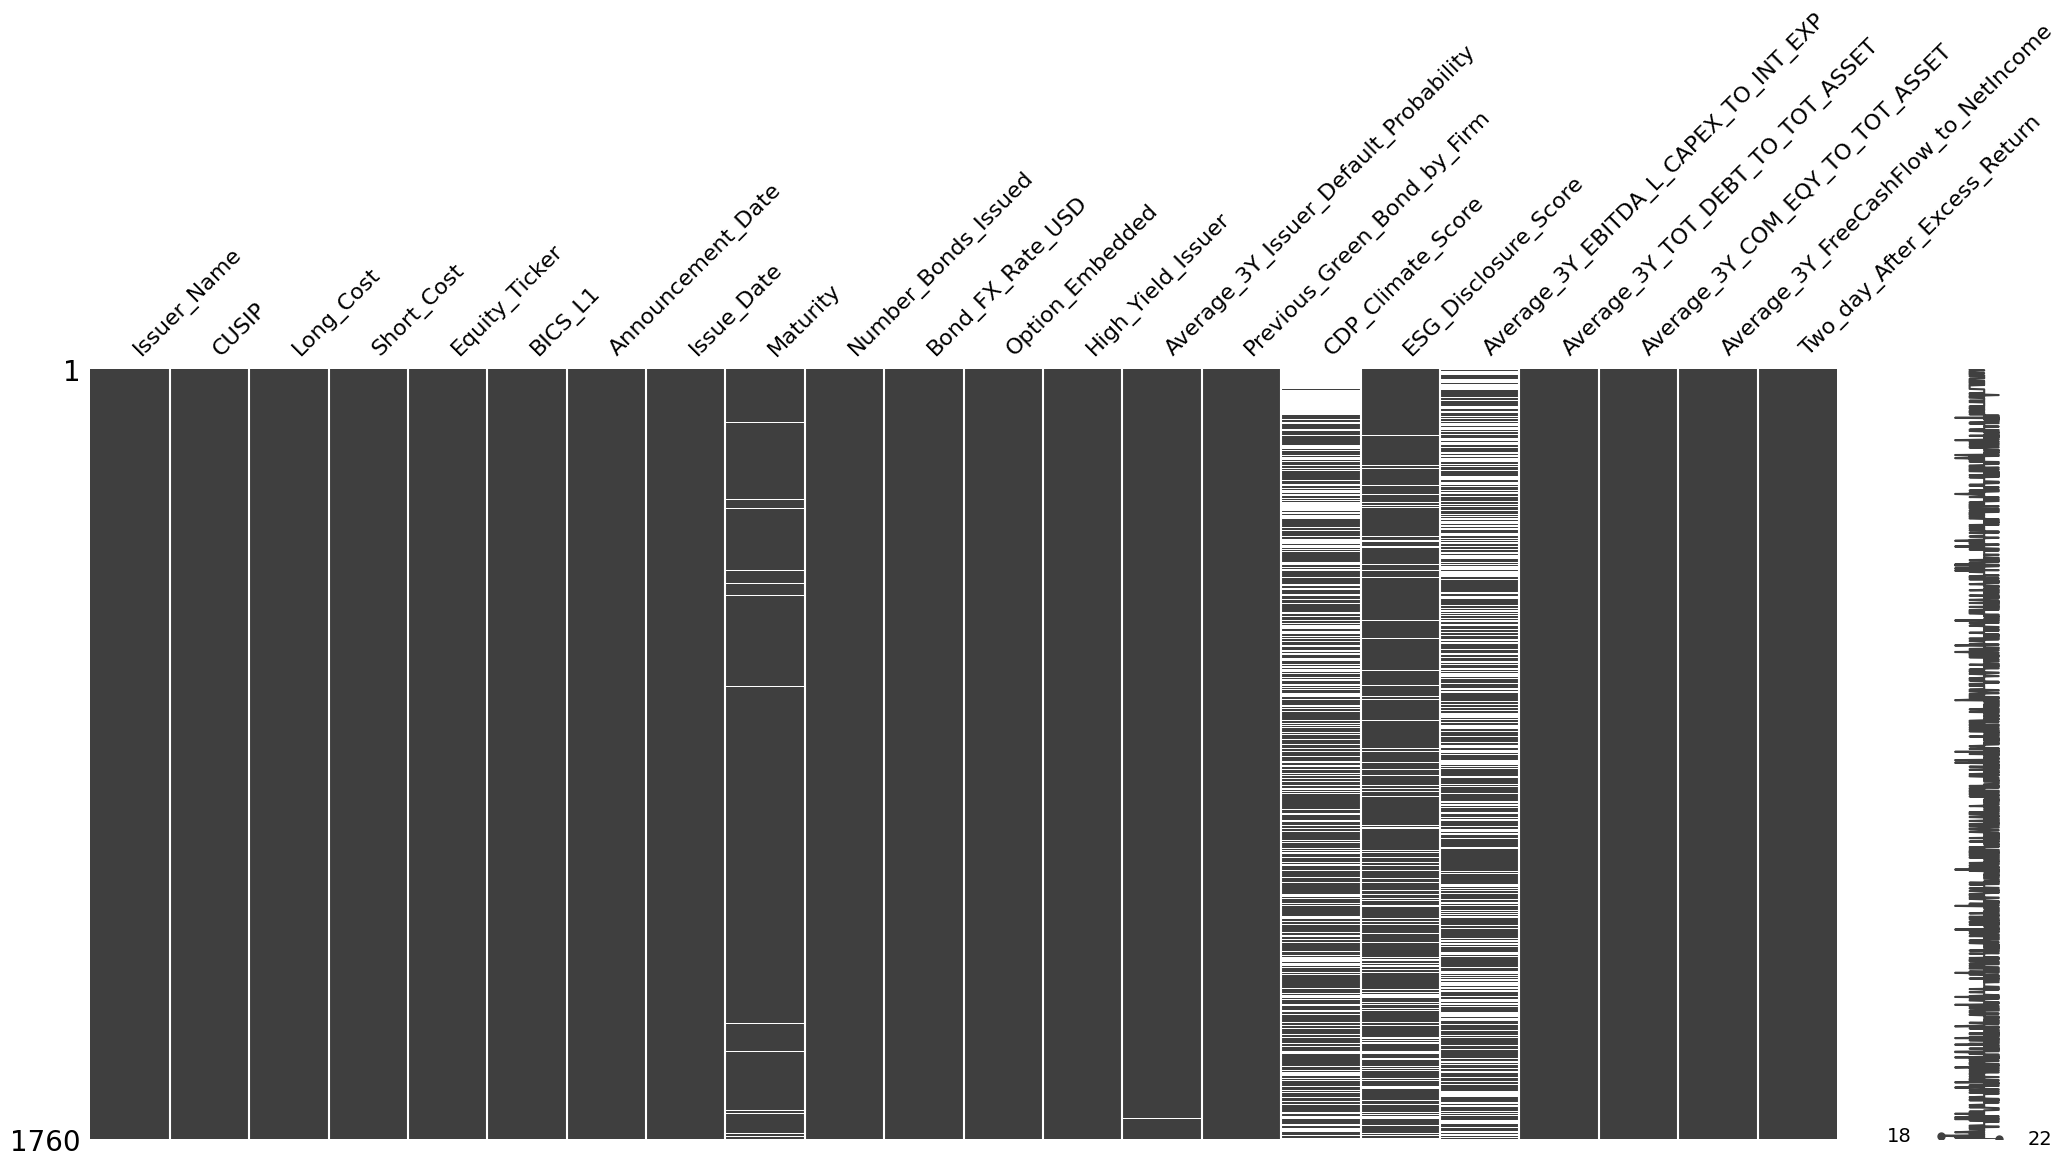

In [30]:
missingno.matrix(GreenBonds)
plt.show()

Darkly-shaded values are non-missing, blank spaces indicate missing or 'n/a' values.

A couple of variables have a lot of missing data, with one of the variables linked to an ESG indicator (CDP Climate Score),
and another linked to a profitability indicator (EBITDA)$^*$. This could be linked to the sector the firm is operating in.
Let's explore why, by looking at the relationship between missing values, and the main sector of the firm.

$^*$EBITDA stands for <b>E</b>arnings <b>b</b>efore (accounting for) <b>I</b>nterest, <b>T</b>ax, <b>D</b>epreciation and <b>A</b>mortisation.
The 'ITDA' in EBITDA represents values that detract from the final profitability of the firm, hence, financial analysts
will want a view of the profitability of the firm before these values are stripped out.

In [31]:
GB = GreenBonds.copy()
GB['ESG'] = GB['CDP_Climate_Score'].isna()
GB['EBITDA_NAs'] = GB['Average_3Y_EBITDA_L_CAPEX_TO_INT_EXP'].isna()

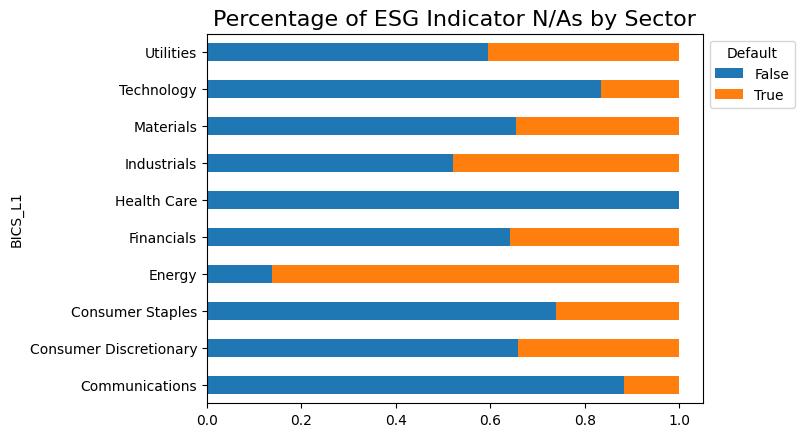

In [32]:
ax = GB.groupby('BICS_L1')['ESG'] \
       .value_counts(normalize=True) \
       .unstack() \
       .plot(kind='barh', stacked='True')
ax.set_title('Percentage of ESG Indicator N/As by Sector',
             fontsize=16)
ax.legend(title='Default', bbox_to_anchor=(1,1))

plt.show()

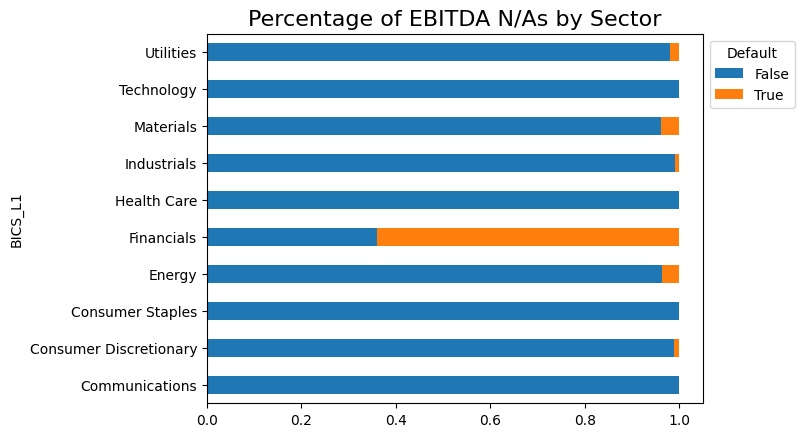

In [33]:
ax = GB.groupby('BICS_L1')['EBITDA_NAs'] \
       .value_counts(normalize=True) \
       .unstack() \
       .plot(kind='barh', stacked='True')
ax.set_title('Percentage of EBITDA N/As by Sector',
             fontsize=16)
ax.legend(title='Default', bbox_to_anchor=(1,1))

plt.show()

We can see a clear pattern for the 'EBITDA' indicators - the Financial Sector accounts for a high number of missing values.

The reason for this is that a significant volume of revenue streams for financial firms are based on interest paid and
received. Since interest payments / receivables form such a crucial part of their business, their 'earnings' before
accounting for interest may be misconstrued as too low, while their interest expense may be misconstrued as too high,
so they do not report EBITDA.

The ESG indicator is evenly-spread across values, with data completeness in the healthcare sector and very low completeness
in the energy sector. This may be due to the specific energy companies within the dataset, who may have previously relied on
non-green fuel sources.

## Subtask 1: Fill 'N/A' values in the `GreenBonds` dataframe.

A naive approach would be to fill all missing data with 0, and that will work just fine, but you are free to follow any
method of your choice as long as you provide a reasonable rationale. Seeing as `GreenBonds` is part of a Pandas dataframe,
you may find help from the pandas documentation: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html

*hint: you will be passing two parameters,* **value =** and **inplace =** *, the latter of which I suggest you set to `True`.*

In [34]:
##**YOUR CODE STARTS HERE**
GreenBonds.fillna(0, inplace=True)
##**YOUR CODE ENDS HERE**

# Data preprocessing

## Subtask 2: Create your set of parameters to be passed into the network

### Required
Some parameters that are included in the `GreenBonds` dataset will not provide any benefit to the modelling process.
Select the parameters that you want to include in your model by creating an 'X_data' dataframe that drops 'Issuer_Name',
'Equity_Ticker', 'BICS_L1','Announcement_Date','Issue_Date', and 'Maturity' from the `GreenBonds` dataframe.

Note that this is also where you should choose your own features to exclude, if you wish to do so for model performance
enhancement. You can do this by adding the variables that you want to 'drop' from the analysis to the function call. If
you are excluding additional variables for the purpose of enhancing modelling performance, please provide your rationale.

*Hint: You may find help on this task from the pandas documentation (you are dropping columns along axis 1):
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html*

In [35]:
#*** YOUR CODE STARTS HERE ***#
GreenBonds['Long_Cost'] = GreenBonds['Long_Cost'].str.rstrip('%')
GreenBonds['Short_Cost'] = GreenBonds['Short_Cost'].str.rstrip('%')
cols_drop = ['CUSIP','Issuer_Name','Equity_Ticker','BICS_L1','Announcement_Date','Issue_Date','Maturity']
X_data = GreenBonds.drop(columns=cols_drop)
X_data
#*** YOUR CODE STARTS HERE ***#

Long_Cost Short_Cost  Number_Bonds_Issued  Bond_FX_Rate_USD   
0         0.04       0.04                    1          0.506100  \
1         0.04       0.04                    1          0.077910   
2         0.05       0.06                    1          0.808500   
3         0.02       0.03                    2          1.000000   
4         0.04       0.04                    2          0.441800   
...        ...        ...                  ...               ...   
1755      0.04       0.04                    1          0.117500   
1756      0.09       0.09                    1          0.008743   
1757      0.04       0.04                    1          0.008794   
1758      0.07       0.07                    1          0.157050   
1759      0.05       0.05                    1          0.156850   

      Option_Embedded  High_Yield_Issuer   
0                   0                  1  \
1                   0                  1   
2                   0                  0   
3                   1                  0   
4                   0                  1   
...               ...                ...   
1755                0                  0   
1756                0                  0   
1757                0                  0   
1758                0                  0   
1759                0                  0   

      Average_3Y_Issuer_Default_Probability  Previous_Green_Bond_by_Firm   
0                                  0.013309                            0  \
1                                  0.013309                            1   
2                                  0.000005                            0   
3                                  0.000039                            1   
4                                  0.013309                            1   
...                                     ...                          ...   
1755                               0.000141                            0   
1756                               0.001750                            1   
1757                               0.000608                            0   
1758                               0.011127                            0   
1759                               0.000094                            0   

      CDP_Climate_Score  ESG_Disclosure_Score   
0                   0.0               47.3684  \
1                   0.0               47.3684   
2                   0.0               23.1405   
3                   0.0               12.8099   
4                   0.0               47.3684   
...                 ...                   ...   
1755                0.0                0.0000   
1756                0.0               51.7544   
1757                0.0               63.2231   
1758                0.0                0.0000   
1759                0.0               50.6224   

      Average_3Y_EBITDA_L_CAPEX_TO_INT_EXP  Average_3Y_TOT_DEBT_TO_TOT_ASSET   
0                                 0.000000                          0.330260  \
1                                 0.000000                          0.330260   
2                                 0.903500                          0.209634   
3                                 7.100633                          0.152386   
4                                 0.000000                          0.330260   
...                                    ...                               ...   
1755                              0.000000                          0.228141   
1756                              0.000000                          0.261003   
1757                              4.153200                          0.279653   
1758                             -4.477200                          0.442767   
1759                              4.483300                          0.157497   

      Average_3Y_COM_EQY_TO_TOT_ASSET  Average_3Y_FreeCashFlow_to_NetIncome   
0                            0.024503                             -2.226958  \
1                            0.024503 

Shuffling the rows of the data randomly, so that our model does not depend on the initial ordering of the data.

In [36]:
# setting random_state for reproducibility - please do not change
X_data = X_data.sample(frac=1, random_state=25).reset_index(drop=True)

**Note**: We will encounter an issue later with the scale of the returns data, which is currently very small. We will
foresee this issue, and sidestep it **now** by multiplying the returns data (`y` variable) by 100. A 1% return is now 1,
5% = 5, and so on.

In [37]:
y = X_data['Two_day_After_Excess_Return']*100
X_data = X_data.drop(['Two_day_After_Excess_Return'], axis = 1)

Get summary statistics for numeric variables:

In [38]:
X_data.describe().transpose().style.format("{:.2f}")

#### Centering and standardising the data

Standardisation involves squeezing all values in each variable into a much smaller range so that variables can be compared
on a 'like for like' basis. If left unchanged, a very low model weight will be assigned to variables with high values,
and high model weights will be assigned to variables with low values. This mismatch may mask the true 'strength' of a
variable's influence on the outcome variable.

As such, standardising / normalising reduces the data in each variable to a smaller range of values, while retaining the
'shape' or the 'distribution' of the original data.

Note it is very important that the 'standardisation' parameters are based on the training set alone. Scikit-learn does
this as part of it's series of operations, but we can also do it manually. Below, we will hardcode it manually.

Note that there are two popular methods of data 'standardisation':

1. min/max scaling involves setting lowest value in variable to 0 and highest to 1, and everything in between to be somewhere
between 0 and 1 according to it's original placement in the set of values. min/max scaling is recommended in contexts where
the range of possible values are fixed, such as in image data with colour intensity measured on a fixed scale of 0-255,
but is problematic in financial settings, as it assumes that the recorded data already contains the lowest and the highest
 set of values that the variable will ever contain.

2. Standard scaling involves centering the data within the variable such that it has a mean of 0, and arranging the ranges
of the value to be re-situated such that the range of the data is one standard deviation from the mean. This is a more flexible
approach to the assumption (and expectation) that future data points may be different to those already captured.

1. First initialise a `StandardScaler()` function.
2. Then fit that function on the first 80% of values in the `x_data` dataframe, to get the required information
 for transforming, and store the fit information it in `scaler`.
3. Then use the information in `scaler` to transform the `x_data` dataframe.

Note that by setting 'training_set_proportion' to 0.8, you are implying that the first 80% of rows will be used as
training data, since our intention is to transform the *entire* dataset (including validation and testing) on the basis
of the centering/standardising parameters of the training set (since the transformation properties in in-sample and
out-of-sample data must match).

In [39]:
def scaled_x_data(x_data, training_set_proportion = 0.8):

    scaler = preprocessing.StandardScaler()
    number_of_observations_in_data = x_data.shape[0]
    scaler.fit(x_data.loc[0:int(number_of_observations_in_data*training_set_proportion)])
    x_scaled = scaler.transform(x_data)

    return x_scaled

In [40]:
scaled_X_data = scaled_x_data(X_data)

Turning the dataset into tensors, so they can be passed into the model (a necessary step in PyTorch), and thereafter
creating subsets of data from the tensor (we already designated the training set, now we designate the validation and test set).

In [41]:
X_tensor = torch.from_numpy(np.array(scaled_X_data)).float()
y_tensor = torch.from_numpy(np.array(y)).float().unsqueeze(dim=1)

BATCH_SIZE = 32
VALID_SIZE = 0.1 # 10%
valid_ind = int(np.floor(len(scaled_X_data)*(1- 2*VALID_SIZE)))
test_ind = int(np.floor(len(scaled_X_data)*(1- VALID_SIZE)))

dataset = TensorDataset(X_tensor, y_tensor)

train_dataset = Subset(dataset, list(range(valid_ind)))
valid_dataset = Subset(dataset, list(range(valid_ind, test_ind)))
test_dataset = Subset(dataset, list(range(test_ind, len(scaled_X_data))))

#### Allocate the size of the mini-batches to be loaded into the model once it begins computing.

In [42]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

Although not a matter of concern here, the above operation let's you control computer memory (if that is the means by which you are carrying out these operations)
in a manageable fashion as you carry out the computations. Rather than loading all data into the model, you can allocate
batches of data such that you are only putting through a certain amount at a time. These are called 'mini-batches'.
'Mini-batches' are typically set in powers of 2, but can be anywhere between 1 (in which case you are conducting
stochastic gradient descent) and the length of the dataset (in which case you are conducting batch gradient descent).

Here we set the mini-batches to include 32 observations at a time.

Larger mini-batch sizes enable faster computation time, but will slow down convergence to the desired minimum (larger
steps toward convergence). Smaller mini-batches will tend to speed up convergence to the desired minimum, but will take
slightly longer to compute (many mini-steps toward convergence).

#### Use naive forecast as a benchmark and evaluate the performance:

In [43]:
print(f"Naive forecast - Buy all stocks that announce bonds. Net Return: {np.sum(y[int(np.floor(len(y)*0.8)):int(np.floor(len(y)*0.9))]):.3f}%")

Naive forecast - Buy all stocks that announce bonds. Net Return: -1.016%


#### Run, Train, and Validate the Efficacy of the Neural Network architecture.

In [44]:
def run_model(nn_model, loss_fn, n_epochs, learning_rate, print_every):
    train_losses, valid_losses = [], []

    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    var_name = re.compile(r'\((.*)\).*$').search(code).groups()[0].split(",", 1)[0]

    optimizer = optim.Adam(nn_model.parameters(), lr=learning_rate)

    for epoch in range(n_epochs):
        running_loss_train = 0
        running_loss_valid = 0

        nn_model.train()

        for x_batch, y_batch in train_loader:

            optimizer.zero_grad()
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            y_hat = nn_model(x_batch)
            loss = loss_fn(y_hat,y_batch)
            loss.backward()
            optimizer.step()
            running_loss_train += loss.item() * x_batch.size(0)

        epoch_loss_train = running_loss_train / len(train_loader.dataset)
        train_losses.append(epoch_loss_train)

        with torch.no_grad():

            nn_model.eval()

            for x_val, y_val in valid_loader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                y_hat = nn_model(x_val)
                loss = loss_fn(y_hat,y_val)
                running_loss_valid += loss.item() * x_val.size(0)

            epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)

            if epoch > 0 and epoch_loss_valid < min(valid_losses):
                best_epoch = epoch
                torch.save(nn_model.state_dict(), f'./{var_name}_checkpoint.pth')

            valid_losses.append(epoch_loss_valid)
        if epoch % print_every == 0:
            print(f"<{epoch}> - Train. loss: {epoch_loss_train:.2f} \t Valid. loss: {epoch_loss_valid:.2f}")
    print(f'Lowest loss recorded in epoch: {best_epoch}')
    return train_losses, valid_losses

### A note on the above:
#### Determining Training Losses
0. **`.zero_grad()`**: The gradients are initialised to zero for each mini-batch that is passed through the model so that the
parameters can be updated correctly. Otherwise, the gradients would be a combination of the old and the new after each pass,
which would interfere with the course of action the backprop operations deems best. In other words, residual gradients may
end up pointing the actual gradient in a different direction than the intended direction (which ideally would be towards the minimum).
1. We load the batches of `X` and `y` data and then apply a .view() transformation that makes the data model-friendly.
.view() is essentially a tensor version of 'reshape' while avoiding copying the data, which allows for fast and memory
efficient reshaping, slicing and element-wise operations. In other words, .view() lets you mould the data into the dimensions
you require (as long as the dimensions match the extent of the data, of course).
2. **`y_hat`** are the predictions from the model, which are then compared to the actual `y` values from the same batch.
The **`loss`**, or averaged error according to the loss function we chose, is computed and stored.
3. `loss.backward()`: Backpropagation computes the gradient of the loss function with respect to the weights, so that
updates to the weights can be pointed in the right direction (i.e. so they reduce loss).
4. `optimizer.step()`: On the basis of the backprop results, the weights are updated.
5. The `running_loss` turns the averaged error (the loss) into the total error associated with the mini-batch.
6. Once all mini-batches have been fed through the model, `epoch_loss` turns the total errors in `running_loss` into the
average loss across the whole epoch.

After each epoch...

#### Finding Validation Losses
7. `torch.no_grad()`: telling the model that for the following operations do not compute gradient updates on the basis of
the losses that are found (i.e. do not 'train' on the basis of the predictions vs. desired results).
8. `model.eval()` is like a switch for the actions of your model: all of the regularisation techniques employed during training
(like dropout in our case) are 'turned off' so that all weights+biases can be used to form predictions.
9. Using the weights of the model that was just computed, we feed in the previously unseen data, and output `y_hat`. For
direct comparison to the real targets in each batch, we also output and assign the actual prices to `y_val`.

## Subtask 3: Define the model

### Required
The main selling point of PyTorch is the flexibility it allows in customising the model you want to compute.
You can create any type of Neural Network you like using the below class, by 'stacking' successive layers line by line,
with non-linearity functions in between. Your task below is to amend the layer details and forward propagation elements
in order to **produce an Artificial Neural Network with a Linear output**.

*Hint:*
1. *Remember that each successive 'layer' in an Artificial Neural Network / Multilayer Perceptron is made up of a `linear`
 function, followed by an activation function. Linear layers in the `__init__` function require you to pass two arguments:
 i) the number of input parameters and ii) the number of parameters to be passed to the next layer.*
2. *You model should contain no more than 3 hidden layers.*
3. *Your implementation may benefit from the use of Dropout. You can find more information about Dropout in PyTorch here: https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html*
4. *You may find the PyTorch documentation helpful in structuring your code for the task: https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html.*

In [45]:
# model definition
class MLP(nn.Module):
    # define model elements
    def __init__(self, n_inputs):
    # layer details
        super(MLP, self).__init__()
        #*** YOUR CODE STARTS HERE ***#
        self.layers = nn.Sequential(
            nn.Linear(n_inputs, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, 1),
        )
        #*** YOUR CODE ENDS HERE ***#
    # forward propagation elements
    def forward(self, m):
        #*** YOUR CODE STARTS HERE ***#
        m = self.layers(m)
        #*** YOUR CODE ENDS HERE ***#
        return m

## Subtask 4: Run and train the model
#### You will be passing through a user-defined loss function, and specifying the number of epochs, learning rate, and update steps.

A couple notes at runtime:

- It is standard to:
    1. train the network for anywhere between 100 and 2000 epochs, depending on the progress of the loss function. All
    things held equal, the number of epochs is dependent on the learning rate
	2. using a learning rate of anywhere between 10^-1 to 10^-6.
	3. have 20 printed progress updates (i.e. if n_epoch = 500, PRINT_EVERY may be set to 25).

- If you get an `UnboundLocalError: local variable 'best_epoch' referenced before assignment` error code, that means the
neural network does not beat the baseline loss (step 0) in any of the following `n_epoch` learning steps. You may need to reconfigure your
(in order) i) learning rate, ii) network architecture, iii) variables included in the analysis.

- To know which loss function to implement, cross-check Lecture 6, Slide 2 with the following documentation: https://pytorch.org/docs/stable/nn.html#loss-functions

In [46]:
MLP_model = MLP(scaled_X_data.shape[1]).to(device)
#*** YOUR CODE STARTS HERE ***#
epochs = 2000
lr = 0.0001
loss_fn = nn.MSELoss()
train_losses, valid_losses = run_model(MLP_model, loss_fn, epochs, lr, int(epochs/20))
#*** YOUR CODE ENDS HERE ***#

<0> - Train. loss: 1.11 	 Valid. loss: 0.96
<100> - Train. loss: 1.02 	 Valid. loss: 0.89
<200> - Train. loss: 0.96 	 Valid. loss: 0.85
<300> - Train. loss: 0.98 	 Valid. loss: 0.82
<400> - Train. loss: 0.92 	 Valid. loss: 0.80
<500> - Train. loss: 0.88 	 Valid. loss: 0.79
<600> - Train. loss: 0.92 	 Valid. loss: 0.78
<700> - Train. loss: 0.89 	 Valid. loss: 0.77
<800> - Train. loss: 0.86 	 Valid. loss: 0.76
<900> - Train. loss: 0.87 	 Valid. loss: 0.75
<1000> - Train. loss: 0.86 	 Valid. loss: 0.74
<1100> - Train. loss: 0.83 	 Valid. loss: 0.74
<1200> - Train. loss: 0.82 	 Valid. loss: 0.72
<1300> - Train. loss: 0.83 	 Valid. loss: 0.73
<1400> - Train. loss: 0.78 	 Valid. loss: 0.72
<1500> - Train. loss: 0.76 	 Valid. loss: 0.72
<1600> - Train. loss: 0.79 	 Valid. loss: 0.72
<1700> - Train. loss: 0.76 	 Valid. loss: 0.72
<1800> - Train. loss: 0.78 	 Valid. loss: 0.72
<1900> - Train. loss: 0.74 	 Valid. loss: 0.72
Lowest loss recorded in epoch: 1710


#### Plot the losses over epochs:

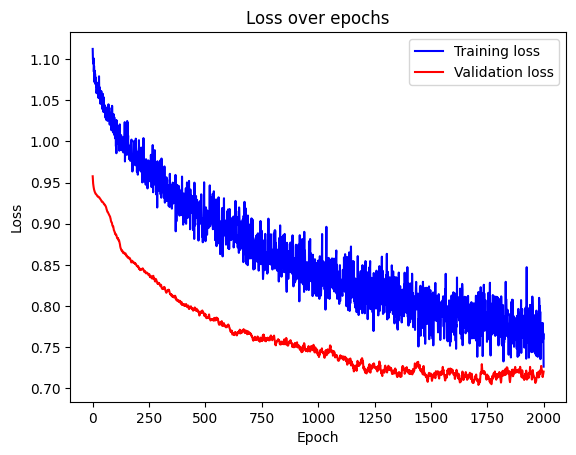

In [47]:
train_losses = np.array(train_losses)
valid_losses = np.array(valid_losses)

fig, ax = plt.subplots()

ax.plot(train_losses, color='blue', label='Training loss')
ax.plot(valid_losses, color='red', label='Validation loss')

ax.set(title='Loss over epochs',
       xlabel='Epoch',
       ylabel='Loss')
ax.legend()
plt.show()

#### Load the best model (with the lowest validation loss), and obtain the predictions on the validation set:

In [48]:
state_dict = torch.load('MLP_model_checkpoint.pth')
MLP_model.load_state_dict(state_dict)

y_pred, y_valid= [], []

with torch.no_grad():

    MLP_model.eval()

    for x_val, y_val in valid_loader:
        x_val = x_val.to(device)
        y_pred.append(MLP_model(x_val))
        y_valid.append(y_val)

y_pred = torch.cat(y_pred).numpy().flatten()
y_valid = torch.cat(y_valid).numpy().flatten()

## Evaluate the predictions on the validation set:
#### Inspecting the performance of the best-performing model by overlaying predictions on observed values.

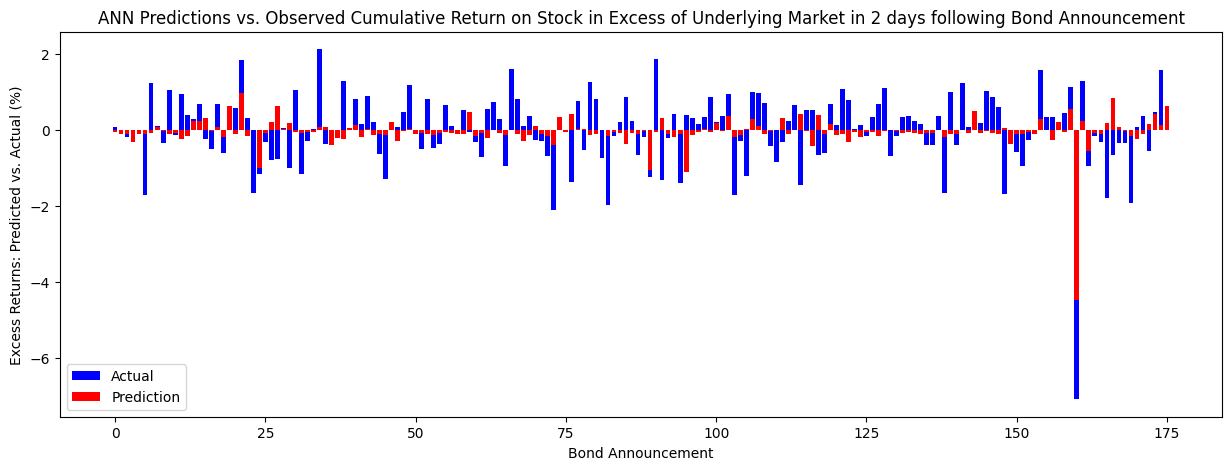

In [49]:
fig, ax = plt.subplots(figsize = (15,5))
ax.bar(range(len(y_valid)),y_valid, color='blue', label= 'Actual')
ax.bar(range(len(y_pred)),y_pred, color='red', label='Prediction')
ax.set(title="ANN Predictions vs. Observed Cumulative Return on Stock in Excess of Underlying Market in 2 days following Bond Announcement",
       xlabel='Bond Announcement',
       ylabel='Excess Returns: Predicted vs. Actual (%)')
ax.legend()
plt.show()

The above graph does not provide much information on the performance of the model in substantive terms.

The way in which the efficacy of the model can be deduced is by measuring the portfolio's performance had you sold the stock when
you heard of an upcoming bond announcement and anticipated negative returns, and bought when positive returns were predicted.
To do this, determine the locations of the 'signs' of the data:

1. Predictions of Positive Performance ('Long the Stock'): Find the positions in the 'prediction set' where the sign of
the predictions were _positive_, and return the result of these positions in the 'observed set'. Sum these values to achieve
the net profit associated with _buying_ the stock.

2. Predictions of Negative Performance ('Short the Stock'): Find the positions in the 'prediction set' where the sign of
the predictions were _negative_, and return the result of these positions in the 'observed set'. Sum these values to achieve
the net profit associated with _selling_ the stock. Note that the code here contains a 'minus', since the observed
excess return is expected to be negative.

3. Combined Performance: Sum '1' and '2'.

In [50]:
stats = {'Number of Long Positions & Results': str(len(np.where(y_pred > 0)[0]))+ ", " + "{:.2f}".format(np.sum(y_valid[np.where(y_pred > 0)]))+"%",
         'Short Positions: Number of Trades & Results': str(len(np.where(y_pred < 0)[0]))+ ", " + "{:.2f}".format(-np.sum(y_valid[np.where(y_pred < 0)]))+"%",
         'Combined Positions: Number of Trades & Results': str(len(np.where(y_pred > 0)[0]) + len(np.where(y_pred < 0)[0]))+", " + "{:.2f}".format((np.sum(y_valid[np.where(y_pred > 0)]) - np.sum(y_valid[np.where(y_pred < 0)])))+"%"
        }
print(stats)

{'Number of Long Positions & Results': '51, 7.63%', 'Short Positions: Number of Trades & Results': '125, 8.64%', 'Combined Positions: Number of Trades & Results': '176, 16.27%'}


### Final Subtask

## **Report your Results & Reflect on your choices in each subtask here:**

The loss function I chose to use is the MSELoss with learning rate of 0.0001. The model is trained for 2000 epochs.
- Model: The model I chose to use consists of 2 hiden layers each with a ReLU activation function and a dropout of 20%. The output layer is a linear function to generate a number.
- Loss Function: nn.MSELoss is used because it is suitable for continuous output.  
- Learning Rate: I used 0.0001 as it makes the training more gradual compared to 0.001 because we dont have lots of data with many features which ensures the speed of training is acceptable. On the other hand, a large LR might converge to suboptimal solution.
- Epochs: Initially I chose 1000 epochs but it does not seem to reach the best solution with the above parameters. Changing to 2000 epochs allows the model to reach a better optima.


Fill in your final results:

> Executing on Positive Association:  ** 51 trades, net return: 7.63%**

> Executing on Negative Association: ** 125 trades, net return: 8.64%**

> Executing on all predictions: ** 176 trades, net return: 16.27%**

> Does your performance exceed the naive forecast of buying the underlying stock every time a upcoming bond is announced?: **net return: -1.02%**) Yes




____